# Supervised Learning Approach

(Insert explanation of our process here)

## Supervised Learning Approach

In [60]:
import numpy as np
import pandas as pd
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Embedding
from keras.layers import LSTM
from keras import optimizers
from keras.callbacks import CSVLogger
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from tqdm import tqdm_notebook
import os

TIME_STEPS = 10
BATCH_SIZE = 10

### Reading Stock Data

In [61]:
msft = pd.read_csv("./Individual_Stock_Data/MSFT.csv")

In [62]:
msft.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-01-04,30.62,31.10,30.59,30.95,24.53,38409100
1,2010-01-05,30.85,31.10,30.64,30.96,24.53,49749600
2,2010-01-06,30.88,31.08,30.52,30.77,24.38,58182400
3,2010-01-07,30.63,30.70,30.19,30.45,24.13,50559700
4,2010-01-08,30.28,30.88,30.24,30.66,24.30,51197400


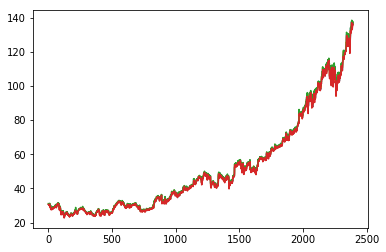

In [63]:
plt.figure()
plt.plot(msft["Open"])
plt.plot(msft["Close"])
plt.plot(msft["High"])
plt.plot(msft["Low"])
plt.show()

### Normalize Data

In [64]:
df_train, df_test = train_test_split(msft, train_size=0.84, test_size=0.16, shuffle=False)

In [65]:
df_train.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-01-04,30.62,31.10,30.59,30.95,24.53,38409100
1,2010-01-05,30.85,31.10,30.64,30.96,24.53,49749600
2,2010-01-06,30.88,31.08,30.52,30.77,24.38,58182400
3,2010-01-07,30.63,30.70,30.19,30.45,24.13,50559700
4,2010-01-08,30.28,30.88,30.24,30.66,24.30,51197400


In [66]:
df_test.head()

,Date,Open,High,Low,Close,Adj Close,Volume
2009,2017-12-26,85.31,85.53,85.03,85.40,83.28,9891200
2010,2017-12-27,85.65,85.98,85.22,85.71,83.58,14678000
2011,2017-12-28,85.90,85.93,85.55,85.72,83.59,10594300
2012,2017-12-29,85.63,86.05,85.50,85.54,83.42,18717400
2013,2018-01-02,86.13,86.31,85.50,85.95,83.82,22483800


In [67]:
train_cols = ["Open", "High", "Low", "Close", "Volume"]
print("Train and Test Size:", len(df_train), len(df_test))
x = df_train.drop(columns=["Date"]).values
min_max_scaler = MinMaxScaler()

# Transforming Data
x_train = min_max_scaler.fit_transform(x)
x_test = min_max_scaler.fit_transform(df_test.drop(columns=["Date"]).values)

Train and Test Size: 2009 383


In [68]:
x_train.shape, x_test.shape

((2009, 6), (383, 6))

## Build Time-Series Structure

In [69]:
def build_timeseries(mat, y_col_index):
    # y_col_index is the index of column that would act as output column
    # total number of time-series samples would be len(mat) - TIME_STEPS
    dim_0, dim_1 = mat.shape[0] - TIME_STEPS, mat.shape[1]
    x = np.zeros((dim_0, TIME_STEPS, dim_1))
    y = np.zeros((dim_0,))
    for i in range(dim_0):
        x[i] = mat[i:TIME_STEPS+i]
        y[i] = mat[TIME_STEPS+i, y_col_index]
    print("length of time-series i/o",x.shape,y.shape)
    return x, y

def trim_dataset(mat, batch_size):
    """
    trims dataset to a size that's divisible by BATCH_SIZE
    """
    no_of_rows_drop = mat.shape[0]%batch_size
    if(no_of_rows_drop > 0):
        return mat[:-no_of_rows_drop]
    else:
        return mat
    
x_t, y_t = build_timeseries(x_train, 3)
x_t = trim_dataset(x_t, BATCH_SIZE)
y_t = trim_dataset(y_t, BATCH_SIZE)
x_temp, y_temp = build_timeseries(x_test, 3)
x_val, x_test_t = np.split(trim_dataset(x_temp, BATCH_SIZE),2)
y_val, y_test_t = np.split(trim_dataset(y_temp, BATCH_SIZE),2)
print("Test size", x_test_t.shape, y_test_t.shape, x_val.shape, y_val.shape)


length of time-series i/o (1999, 10, 6) (1999,)
length of time-series i/o (373, 10, 6) (373,)
Test size (185, 10, 6) (185,) (185, 10, 6) (185,)


In [70]:
lstm_model = Sequential()
lstm_model.add(LSTM(100, batch_input_shape=(BATCH_SIZE, TIME_STEPS, x_t.shape[2]), dropout=0.0, recurrent_dropout=0.0, stateful=True,     kernel_initializer='random_uniform'))
lstm_model.add(Dropout(0.4))
lstm_model.add(Dense(20,activation='relu'))
lstm_model.add(Dense(1,activation='sigmoid'))
optimizer = optimizers.RMSprop(lr=0.001)
lstm_model.compile(loss='mean_squared_error', optimizer=optimizer)

In [71]:
csv_logger = CSVLogger("stock_supervised.log", append=True)

history = lstm_model.fit(x_t, y_t, epochs=50, verbose=2, batch_size=BATCH_SIZE, #50
                    shuffle=False, validation_data=(trim_dataset(x_val, BATCH_SIZE),
                    trim_dataset(y_val, BATCH_SIZE)), callbacks=[csv_logger])
print(history)


Train on 1990 samples, validate on 180 samples
Epoch 1/50
 - 2s - loss: 0.0054 - val_loss: 0.2981
Epoch 2/50
 - 1s - loss: 0.0155 - val_loss: 0.1918
Epoch 3/50
 - 1s - loss: 0.0082 - val_loss: 0.1630
Epoch 4/50
 - 1s - loss: 0.0054 - val_loss: 0.1359
Epoch 5/50
 - 1s - loss: 0.0048 - val_loss: 0.1324
Epoch 6/50
 - 1s - loss: 0.0044 - val_loss: 0.1009
Epoch 7/50
 - 1s - loss: 0.0034 - val_loss: 0.1054
Epoch 8/50
 - 1s - loss: 0.0032 - val_loss: 0.1103
Epoch 9/50
 - 1s - loss: 0.0033 - val_loss: 0.1238
Epoch 10/50
 - 1s - loss: 0.0035 - val_loss: 0.1068
Epoch 11/50
 - 1s - loss: 0.0030 - val_loss: 0.0789
Epoch 12/50
 - 1s - loss: 0.0024 - val_loss: 0.0787
Epoch 13/50
 - 1s - loss: 0.0024 - val_loss: 0.0726
Epoch 14/50
 - 1s - loss: 0.0020 - val_loss: 0.0540
Epoch 15/50
 - 1s - loss: 0.0016 - val_loss: 0.0414
Epoch 16/50
 - 1s - loss: 0.0012 - val_loss: 0.0373
Epoch 17/50
 - 1s - loss: 0.0010 - val_loss: 0.0365
Epoch 18/50
 - 1s - loss: 8.8899e-04 - val_loss: 0.0383
Epoch 19/50
 - 1s - lo

In [72]:
y_pred = lstm_model.predict(trim_dataset(x_test_t, BATCH_SIZE), batch_size=BATCH_SIZE)
y_pred = y_pred.flatten()
y_test_t = trim_dataset(y_test_t, BATCH_SIZE)
error = mean_squared_error(y_test_t, y_pred)
print("Error is", error, y_pred.shape, y_test_t.shape)

# convert the predicted value to range of real data
y_pred_org = (y_pred * min_max_scaler.data_range_[3]) + min_max_scaler.data_min_[3]
# min_max_scaler.inverse_transform(y_pred)
y_test_t_org = (y_test_t * min_max_scaler.data_range_[3]) + min_max_scaler.data_min_[3]

print(y_pred_org[0:15])
print(y_test_t_org[0:15])

Error is 0.006453084124013345 (180,) (180,)
[117.00302  116.20404  114.640976 113.520836 114.06329  111.64198
 108.56177  111.51599  112.233086 113.41848  114.453384 113.15268
 112.09328  112.532196 111.24293 ]
[112.79 112.13 110.85 112.26 106.16 105.91 109.57 107.6  111.   110.71
 108.5  108.66 109.63 108.1  102.32]


<Figure size 432x288 with 0 Axes>

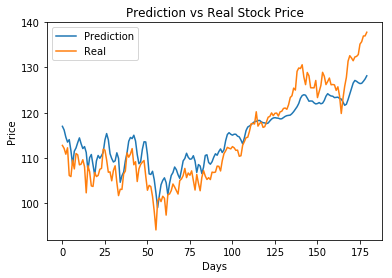

<Figure size 432x288 with 0 Axes>

In [73]:
from matplotlib import pyplot as plt
plt.figure()
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('Model loss')
# plt.ylabel('Loss')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Test'], loc='upper left')
# #plt.show()
# plt.savefig( 'train_vis_BS_.png')

from matplotlib import pyplot as plt
plt.figure()
plt.plot(y_pred_org)
plt.plot(y_test_t_org)
plt.title('Prediction vs Real Stock Price')
plt.ylabel('Price')
plt.xlabel('Days')
plt.legend(['Prediction', 'Real'], loc='upper left')
plt.show()
plt.savefig('pred_vs_real_BS_.png')


In [74]:
from keras import backend as K

def coeff_determination(y_true, y_pred):

    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - np.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

R_2 = coeff_determination(y_test_t_org, y_pred_org)
with tf.Session() as sess:  
    print(R_2.eval()) 


0.8192801700190238
